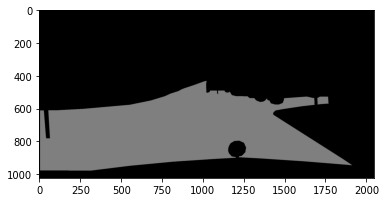

In [72]:
# Used to layer all semantic masks one at a time to see what resulting road mask is. This is deprecated and not used in the final project.

import json
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

# Path to the JSON file and the size of the image (width, height)
json_path = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_polygons.json"

with open(json_path, 'r') as f:
    data = json.load(f)

# Extract image dimensions from the JSON
img_height = data['imgHeight']
img_width = data['imgWidth']

# Create a blank image (mask) with the same dimensions
# Using 'L' mode for grayscale
mask = Image.new('L', (img_width, img_height), 0)  # 0 means the background

# Initialize ImageDraw to draw on the mask
draw = ImageDraw.Draw(mask)

priority_mapping = {
    "sky": 1,
    "road": 21,
    # Add other labels as needed
    "car": 3,
    "sidewalk": 4,
    "vegetation": 5,
    "pole": 6,
    "building": 7,
    "traffic sign": 8,
    "fence": 9,
    "static": 10,
    "person": 11,
    "ego vehicle": 12,
    "rectification border": 13,
    "out of roi": 14,
    "truck": 15,
    "bus": 16,
    "on rails": 17,
    "motor": 18,
    "bicyc": 19,
    "rider": 2
}

# Initialize a mask to track areas already occupied by higher-priority labels
occluded_areas = Image.new('L', (img_width, img_height), 0)

# Sort objects by priority (ascending order)
objects_sorted = sorted(data['objects'], key=lambda obj: priority_mapping[obj['label']])

# First, create the mask for all labels (to track occluded areas)
for obj in objects_sorted:
    label = obj['label']
    polygon = obj['polygon']
    
    # Convert the polygon from list of lists to list of tuples
    polygon = [tuple(point) for point in polygon]
    
    # Get the grayscale value for the label
    grayscale_value = priority_mapping[label]
    
    # If the label has a higher priority (we care about the occlusion of the "road" class)
    if label != "road":
        # Draw the current object on the occlusion mask
        draw_temp = ImageDraw.Draw(occluded_areas)
        draw_temp.polygon(polygon, outline=grayscale_value, fill=grayscale_value)

# Now create the occluded road mask, which is only the road regions occluded by higher-priority labels
road_mask = Image.new('L', (img_width, img_height), 0)  # Start with a blank road mask

# Iterate through the "road" objects
for obj in data['objects']:
    if obj['label'] == "road":
        polygon = obj['polygon']
        
        # Convert the polygon from list of lists to list of tuples
        polygon = [tuple(point) for point in polygon]
        
        # Draw the "road" polygon on the road_mask
        draw_temp = ImageDraw.Draw(road_mask)
        draw_temp.polygon(polygon, outline=21, fill=21)  # Set to grayscale value 2 for "road"

# Convert both occlusion masks to NumPy arrays for easier manipulation
mask_array = np.array(mask) # blank mask
bw_image = (~(np.array(occluded_areas) > 0)).astype(np.uint8)*127
rgb_image = cv2.cvtColor(bw_image, cv2.COLOR_GRAY2BGR)
# alpha_channel = np.full(rgb_image.shape, 255, dtype=np.uint8)
# Merge RGB and alpha channels to create a 4-channel (RGBA) image
# rgba_image = cv2.merge((bw_image, alpha_channel))
plt.imshow(rgb_image)
# print(occluded_areas_array[500:510,500:510])
plt.show()
# road_mask_array = np.array(road_mask)
# plt.imshow(road_mask_array)
# plt.show()

# # Now subtract the occluded areas from the road mask to get only the "occluded" road areas
# # occluded_road = (road_mask_array == 21) & (occluded_areas_array > 0)
# occluded_road = np.where((road_mask_array == 21) & (occluded_areas_array > 0), 1, 0)

# # Convert the result back to a Pillow image
# print(occluded_areas_array[600:610,200:210])
occluded_road_mask = Image.fromarray(rgb_image)
# plt.imshow(occluded_road)
# plt.show()

# Save and show the final occluded road mask
occluded_road_mask.save('occluded_road_mask.png')
occluded_road_mask.show()

Image loaded successfully.
Image shape: (1024, 2048, 4)
shape (1024, 2048, 3)
occluded_areas_array shape (1024, 2048)
img road shape (1024, 2048, 3)


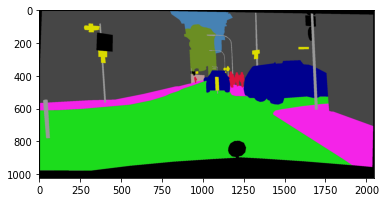

In [55]:
# This cell checks to ensure the road mask is aligned with the original image. Not necessary to process data

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the image
# image_path = 'cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'
image_path = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'

# Verify if the file exists
if not os.path.exists(image_path):
    print(f"File not found: {image_path}")
else:
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print("Failed to load image. Check the file format or path.")
    else:
        print("Image loaded successfully.")
        print("Image shape:", img.shape)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print('shape',img_rgb.shape)

        # Display the image
        plt.imshow(img_rgb)

print('occluded_areas_array shape', occluded_areas_array.shape)
img_road = cv2.cvtColor(occluded_areas_array * 100, cv2.COLOR_GRAY2BGR)
print('img road shape', img_road.shape)
img_composite = img_rgb - img_road
plt.imshow(img_composite)
        

Image loaded successfully.
Image shape: (1024, 2048)
type uint8


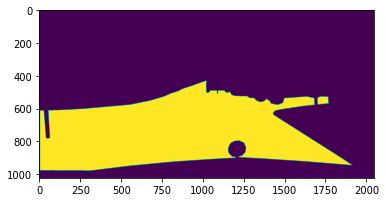

In [77]:
# Display mask where semantic image label equals road class (7)

from PIL import Image
import numpy as np

image_path = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png'

# Open the image using Pillow
img_pil = Image.open(image_path)

# Convert to a NumPy array
img_np = np.array(img_pil)

print("Image loaded successfully.")
print("Image shape:", img_np.shape)
print('type',img_np.dtype)
# print(np.where(img_np == 7,1,0))
# print(img_np[410:430,500:510])

plt.imshow(np.where(img_np == 7,1,0))


In [80]:
# Create binary mask where semantic image label equals road class (7). Necessary to produce validation dataset

import os
import numpy as np
from PIL import Image

def process_pngs(input_dir, output_dir, target_value=7, new_value=1, default_value=0):
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Process each PNG file in the input directory
    for file_name in os.listdir(input_dir):
        if file_name.endswith('labelIds.png'):
            # Load the PNG file as a NumPy array
            input_path = os.path.join(input_dir, file_name)
            img = Image.open(input_path)
            img_np = np.array(img)

            # Apply the mask
            masked_np = np.where(img_np == target_value, new_value, default_value).astype(np.uint8)

            # Convert back to a PNG image
            masked_img = Image.fromarray(masked_np * 255)  # Scale 1 and 0 to 255 and 0 for PNG visualization

            # Save the processed image
            output_path = os.path.join(output_dir, file_name)
            masked_img.save(output_path)

            print(f"Processed and saved: {output_path}")

input_directory = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt'
output_directory = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt'
process_pngs(input_directory, output_directory, target_value=7, new_value=1, default_value=0)


Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000001_080091_gtFine_labelIds.png
Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000001_073243_gtFine_labelIds.png
Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000001_010156_gtFine_labelIds.png
Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000001_023369_gtFine_labelIds.png
Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000001_051516_gtFine_labelIds.png
Processed and saved: /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/gtFine/val/frankfurt_gt/frankfurt_000000_011007_gtFine_labelIds.png
Processed and sa

In [13]:
# Create dummy json files. Necessary to produce validation dataset

import os
import json

empty_json = {
    "name": "",
    "frames": [
        {
            "timestamp": 0,
            "objects": [
                {
                    "category": "",
                    "id": 0,
                    "attributes": {
                        "occluded": False,
                        "truncated": False,
                        "trafficLightColor": ""
                    },
                    "box2d": {
                        "x1": 0.0,
                        "y1": 0.0,
                        "x2": 0.0,
                        "y2": 0.0
                    }
                }
            ]
        }
    ]
}

# Paths
source_folder = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/images/val"
destination_folder = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/objects/val"

# Ensure the destination folder exists
os.makedirs(destination_folder, exist_ok=True)

# Iterate through each file in the source folder
for file_name in os.listdir(source_folder):
    file_path = os.path.join(source_folder, file_name)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        # Get the file name without extension and add '.json'
        json_file_name = os.path.splitext(file_name)[0] + ".json"
        json_file_path = os.path.join(destination_folder, json_file_name)
        
        # Save the empty JSON file
        with open(json_file_path, 'w') as json_file:
            json.dump(empty_json, json_file, indent=4)

# print(f"Empty JSON files saved in {destination_folder}.")


In [86]:
# Rename files to only include the "xx_yy" number in their name, reformat as necessary.
# This ensures the same name across all images and labels, which is nessary for YOLOP validation to run correctly.

import os

folder_path = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/data/frank_seg_gt/val'

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(file_path):
        # Split the filename and extract the number
        base_name = file_name.split('_')
        number = base_name[1]+ '_' + base_name[2]  # Assuming the number is at index 2

        # print(number)

        # Create the new filename
        new_file_name = f"{number}.png"  # Adjust the file extension as needed
        new_file_path = os.path.join(folder_path, new_file_name)
        
        # Rename the file
        os.rename(file_path, new_file_path)

print(f"Files renamed in {folder_path}.")


Files renamed in /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/cityscapes/data/frank_seg_gt/val.


In [11]:
# Create empty image of the same size and names as the image directory. This is necessary
# to ensure YOLOP has inputs for all labels when it tries to perform inference 

import os
from PIL import Image
import numpy as np

source_dir = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/images/val"
destination_dir = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/driveable/val"

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Iterate through each file in the source directory
for file_name in os.listdir(source_dir):
    source_file_path = os.path.join(source_dir, file_name)
    
    # Check if it's a file (not a directory)
    if os.path.isfile(source_file_path):
        # Open the source image to get its dimensions
        with Image.open(source_file_path) as img:
            width, height = img.size
        
        # Create an empty numpy array filled with zeros (black image)
        empty_mask = np.zeros((height, width), dtype=np.uint8)
        
        # Convert the numpy array to a PIL Image
        empty_image = Image.fromarray(empty_mask)
        
        dest_file_name = os.path.splitext(file_name)[0] + ".png"
        destination_file_path = os.path.join(destination_dir, dest_file_name)
        
        # Save the empty mask as a PNG file
        empty_image.save(destination_file_path)

print(f"Empty masks created in {destination_dir}.")


Empty masks created in /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/driveable/val.


In [8]:
# This creates a binary segmentation mask for lane lines from (x,y) key point coordinates in json format.
# Necessary to allow YOLOP to evaluate on cityscapes which does not have lane segmentation mask labels

import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt

img_width, img_height = 2560, 1440

# Function to read the spline points from a JSON file
def read_splines_from_json(json_path):
    splines = []
    with open(json_path, 'r') as file:
        data = json.load(file)
        for line in data['Lines']:
            spline = [(float(point['x']), float(point['y'])) for point in line]
            splines.append(spline)
    return splines

# Function to create the lane mask image
def create_lane_mask(json_path, output_path):
    # Create a black image
    img = np.zeros((img_height, img_width), dtype=np.uint8)

    # Read the spline data from the JSON file
    splines = read_splines_from_json(json_path)

    # Draw each spline as a white line on the black image
    for spline in splines:
        points = np.array(spline, dtype=np.int32)
        points = points.reshape((-1, 1, 2))  # Reshape to match OpenCV's polyline format
        cv2.polylines(img, [points], isClosed=False, color=255, thickness=5)

    # image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # # Display the image using Matplotlib
    # plt.imshow(image_rgb)
    # plt.axis('off')  # Turn off the axis labels
    # plt.title('Image')  # Optional: Add a title
    # plt.show()

    # Save the image to the specified output path
    cv2.imwrite(output_path, img)
    print(f'Lane mask saved to {output_path}')

# Function to process all JSON files in an input folder
def process_all_files(input_folder, output_folder):
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            json_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace('.json', '.png'))

            # Create the lane mask for each file
            create_lane_mask(json_path, output_path)

In [10]:

# Run the functions above with specified input/output folders
input_folder = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/valid/labels' 
output_folder = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val'
process_all_files(input_folder, output_folder)

Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/00bf4dc4c2ccbff61f9b60d218431bd0.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/f3951799c90d932745bc3bb8b12cf44f.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/ad0f21fd0e9cee2d7f109cc2a68fbd27.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/b5d1b80f1567e0af19ab71cc9dcbfd44.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/6e538b5214d369768e09a2324d8c0a84.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val/367451998b07cce5dcb0ece9426e1665.lines.png
Lane mask saved to /home/tylergs/ondemand/data/sys/myjobs/

In [12]:
# Helper function to ensure file name consistency

import os

directory = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val"  

# Iterate through each file in the directory
for filename in os.listdir(directory):
    # Check if the file contains ".lines"
    if ".lines" in filename:
        # Create the new filename by replacing ".lines"
        new_filename = filename.replace(".lines", "")
        # Get the full paths for the old and new filenames
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        # Rename the file
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {new_filename}")

# print("Renaming completed.")


Renamed: fbd2810a8600738a802da0176030c4ac.lines.png -> fbd2810a8600738a802da0176030c4ac.png
Renamed: cf3b7909ba8e129d1e6b6ad3b4de2c2b.lines.png -> cf3b7909ba8e129d1e6b6ad3b4de2c2b.png
Renamed: 3f29bb6d3f33d6ecaa5646e3561b17a7.lines.png -> 3f29bb6d3f33d6ecaa5646e3561b17a7.png
Renamed: ffea7fc6a850cf63e4de8e2b17a8cf86.lines.png -> ffea7fc6a850cf63e4de8e2b17a8cf86.png
Renamed: 7b3823b8bd34bc41a762e33949f43a31.lines.png -> 7b3823b8bd34bc41a762e33949f43a31.png
Renamed: 2200bd7eddb81d62fa5421b3fa715e3e.lines.png -> 2200bd7eddb81d62fa5421b3fa715e3e.png
Renamed: ae2774b6c7ba2916377231fe595d4b68.lines.png -> ae2774b6c7ba2916377231fe595d4b68.png
Renamed: aa4b1e2d7071ee903f01aec92808e35d.lines.png -> aa4b1e2d7071ee903f01aec92808e35d.png
Renamed: 875128a1394c720fff804bbb676fc995.lines.png -> 875128a1394c720fff804bbb676fc995.png
Renamed: 338be476f88cdf34c30b2e7ed9e4a461.lines.png -> 338be476f88cdf34c30b2e7ed9e4a461.png
Renamed: 03210862e0e4630f74c18483375763c3.lines.png -> 03210862e0e4630f74c184833

In [ ]:
# Converts files from jpg to png. Not used in data preparation

import os
from PIL import Image

input_directory = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/images/val"  
output_directory = "/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/images2/val"  

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Iterate through the files in the input directory
for filename in os.listdir(input_directory):
    if filename.lower().endswith(".jpeg") or filename.lower().endswith(".jpg"):  # Check for JPEG files
        input_path = os.path.join(input_directory, filename)
        output_filename = os.path.splitext(filename)[0] + ".png"  # Replace extension with .png
        output_path = os.path.join(output_directory, output_filename)

        # Open the JPEG image and save it as a PNG
        with Image.open(input_path) as img:
            img.save(output_path, "PNG")
            # print(f"Converted: {filename} -> {output_filename}")

print("Conversion completed.")


In [24]:
# Ensures all images within target folder are of the same size, which is necessary for YOLOP inference to run properly.

import os
import cv2
import numpy as np

# Function to resize and pad images to the target size
def resize_and_pad_image(img, target_width, target_height):
    h, w = img.shape[:2]
    ratio = min(target_width / w, target_height / h)
    new_w = int(w * ratio)
    new_h = int(h * ratio)

    # Resize the image while maintaining the aspect ratio
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create a black canvas with the target size
    padded_img = np.zeros((target_height, target_width, 3), dtype=np.uint8)

    # Place the resized image on the center of the canvas
    top = (target_height - new_h) // 2
    left = (target_width - new_w) // 2
    padded_img[top:top+new_h, left:left+new_w] = img_resized

    return padded_img

def check_and_resize_folders(images_folder, masks_folder, lane_labels_folder, target_width, target_height):
    # List all files in the folders
    image_files = sorted(os.listdir(images_folder))
    mask_files = sorted(os.listdir(masks_folder))
    lane_label_files = sorted(os.listdir(lane_labels_folder))

    if len(image_files) != len(mask_files) or len(image_files) != len(lane_label_files):
        print("Error: The number of files in the folders do not match!")
        return

    # Iterate through each file in the image folder
    for img_file, mask_file, lane_file in zip(image_files, mask_files, lane_label_files):
        # Construct full file paths
        img_path = os.path.join(images_folder, img_file)
        mask_path = os.path.join(masks_folder, mask_file)
        lane_path = os.path.join(lane_labels_folder, lane_file)

        # Read the image, mask, and lane files
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        lane = cv2.imread(lane_path)

        # Check if the images, masks, and lane labels have the same size
        if img.shape[:2] != mask.shape[:2] or img.shape[:2] != lane.shape[:2]:
            # print(f"Resizing {img_file} and its corresponding mask/lane label...")

            # Resize and pad the image, mask, and lane label
            img_resized = resize_and_pad_image(img, target_width, target_height)
            mask_resized = resize_and_pad_image(mask, target_width, target_height)
            lane_resized = resize_and_pad_image(lane, target_width, target_height)

            # Save the resized images back
            cv2.imwrite(img_path, img_resized)
            cv2.imwrite(mask_path, mask_resized)
            cv2.imwrite(lane_path, lane_resized)

            print(f"Resized {img_file} and its corresponding mask/lane label to {target_width}x{target_height}.")
        # else:
            # print(f"{img_file} and its corresponding mask/lane label already have the correct size.")

images_folder = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/images/val'
masks_folder = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/lanes/val'
lane_labels_folder = '/home/tylergs/ondemand/data/sys/myjobs/projects/535_final/YOLOP/data/Curvelanes/data/driveable/val'

target_width = 2560
target_height = 1440

# Run the check and resize function
check_and_resize_folders(images_folder, masks_folder, lane_labels_folder, target_width, target_height)


Resized 01d4e375e082818ca30e1c8490b0a14b.jpg and its corresponding mask/lane label to 2560x1440.
Resized 01f30539e3fe0a94ad1d2265c101a8dc.jpg and its corresponding mask/lane label to 2560x1440.
Resized 01ff50bba643eccb2ae63d28fb1fefd0.jpg and its corresponding mask/lane label to 2560x1440.
Resized 022929373756c45966a279f12be05075.jpg and its corresponding mask/lane label to 2560x1440.
Resized 02683d04b4c912829a78a9ae0a3bfec0.jpg and its corresponding mask/lane label to 2560x1440.
Resized 026934a008e9d008f5bfeee04ffa1ab1.jpg and its corresponding mask/lane label to 2560x1440.
Resized 026f5245842e29f1e74b30b56ebd3d5e.jpg and its corresponding mask/lane label to 2560x1440.
Resized 027a0d9f8ccd4b10e24a3da800d139e7.jpg and its corresponding mask/lane label to 2560x1440.
Resized 027fd0b794da3c7c8c65141ae4904bd9.jpg and its corresponding mask/lane label to 2560x1440.
Resized 02abfc7a3f8d1411626ed9535ca0586b.jpg and its corresponding mask/lane label to 2560x1440.
Resized 02c97cee43ff86db38cb3f